In [2]:
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
names = open("../names_input.txt", 'r').read().splitlines()

In [4]:
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(names), min(len(w) for w in names), max(len(w) for w in names)

(32033, 2, 15)

In [6]:
chars = sorted(list(set("".join(names))))
vocab_size = len(chars)
print("All unique characters in the text:")
print(''.join(chars)) # First Character is \n, hence the empty line
print("The size of the vocabulary:",vocab_size)

All unique characters in the text:
abcdefghijklmnopqrstuvwxyz
The size of the vocabulary: 26


In [7]:
stoi = {c:i+1 for i,c in enumerate(chars)}
# stoi['<S>'] = vocab_size # Indexing start from 0, so len(chars) will be next index
# stoi['<E>'] = vocab_size + 1
stoi['.'] = 0
# Unlike general convention of start and end token.
# We are using single token `.`, and also making it's index as 0
# offestting all other characters by 1. '.':0, 'a':1, 'b':2, ..., 'z':27
itos = {v:k for k,v in stoi.items()}

In [8]:
total_chrs = max(itos.keys()) + 1 # index 0 to 26
N = torch.zeros((total_chrs,total_chrs), dtype=torch.int16)

In [9]:
for w in names:
    name = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(name, name[1:]):
        idx1, idx2 = stoi[ch1], stoi[ch2]
        N[idx1, idx2] += 1

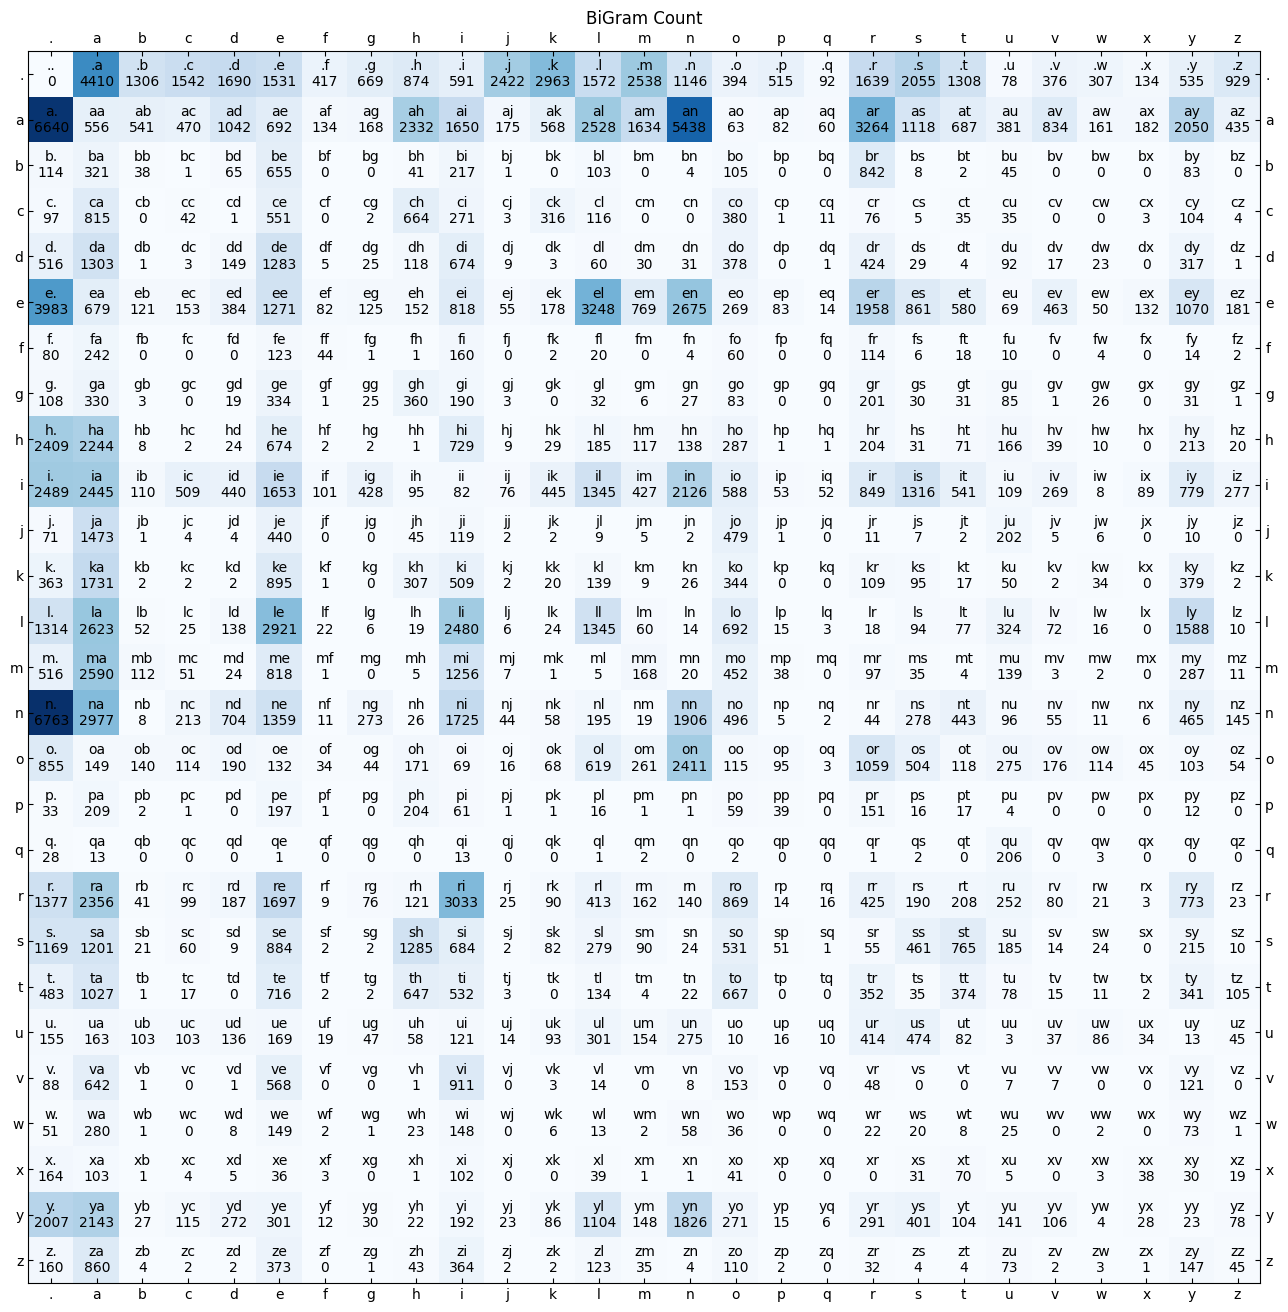

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Creating the figure and the axis
fig, ax = plt.subplots(figsize=(16, 16))

# Creating the heat map
heatmap = ax.imshow(N, cmap='Blues')

# Adding the index values as annotations
for i in range(total_chrs):
    for j in range(total_chrs):
        bigram = itos[i] + itos[j]
        text = f'{bigram}\n{N[i, j]}'
        ax.text(j, i, text, ha='center', va='center', color='black')


# Setting the x-axis and y-axis labels
ax.set_xticks(np.arange(total_chrs))
ax.set_xticklabels(sorted(stoi))
ax.set_yticks(np.arange(total_chrs))
ax.set_yticklabels(sorted(stoi))

# Adding x-axis and y-axis ticks on all four sides
ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in', 
               labeltop=True, labelbottom=True, labelleft=True, labelright=True)


# Setting the title and displaying the plot
ax.set_title('BiGram Count')
plt.show()

In [11]:
# probabilities of first character to be picked up
p = N[0]/N[0].sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [12]:
# Using torch.multinomial to sample output based on probability distribution
g = torch.Generator().manual_seed(2147483647) # deterministic generator for sampling
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

The letter `c` would be the first character after `.` in our generation for the particular seed following the probability distribution of next token after the `.`

### Probability matrix

In [13]:
d = (N+1).sum(dim=1, keepdim=True)
P = (N+1)/d
# N.sum(dim=1, keepdim=True) -> (27,1)
# Division by broadcasting
# N -> 27 27
# d -> 27 1
# d gets broadcasted (27,27)

N+1 for model smoothing  
since, some bigrams has count 0, the probability for them will be 0  
log(0) is `-inf`, hence nll will be `inf`, which doesn't look good  
So we add some constant to all values to avoid `inf` loss  
We can add any constant value, the higher the value higher the smoothning  
hence the more uniform and smooth the model will be.  

In [14]:
P[0].sum() # sanity check

tensor(1.)

In [15]:
# # wrong way to do it, which can be easily missed due to small error
# d = N.sum(dim=1)
# P = N/d
# P[0].sum() # sanity check

clearly, the row sum should be 1, since sum of all probability is 1.   
Here we didn't had `keepdims=True`, which collapsed the sum   
Now shape of `d` is (27)  
When doing broadcasting
```
N -> 27 27  
d ->    27 (dimension should be trailing, i.e. from right)  
```
the row vector of shape (27), will be copied along all rows instead of columns.


### Generation Loop

In [16]:
g = torch.Generator().manual_seed(2147483647) # deterministic generator for sampling

for _ in range(7):
    ix = 0 # starting with `.` idx
    out = []
    while True:
        p = P[ix] # Get the row of the current character token
        # p = N[ix].float() # Get the row of the current character token
        # p /= p.sum() # Normalize    
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample next token
        if ix == 0: # Sample end token
            break
        out.append(itos[ix])
    print(''.join(out))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai


The bigram model is very bad, since it doesn't have any context of the history, it only knows one token before it. So the names `ka`, `da` etc. are two character names, because the model now stops according the last available token, and doesn't know that the generated name consists of 2 tokens only.

##### GOAL: maximize likelihood of the data w.r.t to the model parameters (statistical modelling)
##### equivalent to maximizing log likelihood (since log is monotonic function)
##### equivalant to minimizing negative log likelihood (since we want lower loss as better)
##### equivalent to minimizing average negative log likelihood

### Model Evaluation

In [17]:
log_likelihood = 0
n = 0
for w in names:
    name = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(name, name[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        log_likelihood += torch.log(prob)
        n += 1
        # print(f"{ch1}{ch2} {prob:.4f} {log_likelihood:.4f}")

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(nll/n)

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
tensor(2.4544)


### Training Set for BiGram Model

In [18]:
xs, ys = [], [] # input and corresponding labels

for w in names[:1]:
    name = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(name, name[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


The above has 5 different data points, which can be input to the neural net. For example, when the input is `0`, the expected label is `5`, and in next iteration when input is `5`, the expected label is `13` and so on.

In [19]:
xenc = F.one_hot(xs, num_classes=total_chrs).float() # since NN wants floats not ints
print(xenc.shape)
print(xenc[0])

torch.Size([5, 27])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


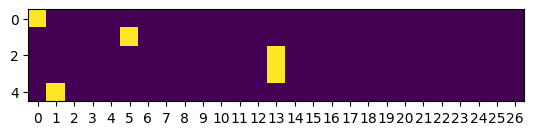

In [20]:
plt.imshow(xenc)
plt.xticks(np.arange(total_chrs))
plt.show()

### Single Neuron

In [21]:
W = torch.rand((total_chrs, 1))
out = xenc @ W
out.shape

torch.Size([5, 1])

**(5,27)@(27,1) -> (5,1)**

In [22]:
# Having 27 Neurons in the network
W = torch.rand((total_chrs, total_chrs))
out = xenc @ W
out.shape

torch.Size([5, 27])

In [23]:
out[3, 13] # dot product of 3rd row of `xenc` and 13th column of `W`

tensor(0.6753)

In [24]:
# sanity check
(xenc[3] * W[:, 13]).sum(), torch.dot(xenc[3], W[:, 13]) # both are dot products

(tensor(0.6753), tensor(0.6753))

The 27x27, weights matrix is the simplest neural network. We would like to train it to do the next token prediction and somewhat acheive to what we have in the previous BiGram model with probabilities.

Here the weights are ranging from roughly -3 to +3, as `torch.rand` samples from a normal distribution with mean 0, but we want it to be more like probabilities, which are never negative.  
So we think the weights as `log-counts` and we exponentiate them to get `counts`

In [25]:
logits = xenc @ W # log-counts
counts = logits.exp() # ~ equivalent to N
prob = counts / counts.sum(1, keepdim=True)
prob[0].sum() # sanity check

tensor(1.0000)

This is what is called `softmax`

### One Forward Pass

In [26]:
# randomly initializing single layer network
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((total_chrs, total_chrs), generator=g, requires_grad=True)

In [27]:
xenc = F.one_hot(xs, num_classes=total_chrs).float()
logits = xenc @ W
counts = logits.exp()
prob = counts/counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([5, 27])

In [28]:
nlls = torch.zeros(5) # for first 5 examples
for i in range(5):
    # for i^th  bigram
    x = xs[i].item() # input char
    y = ys[i].item() # label/targer char
    print("-"*10)
    print(f"bigram example: {itos[x]}{itos[y]} with indices ({[x]}{[y]})")
    print(f"input to the network: {x}")
    print(f"output probabilities from the network: {prob[i]}")
    print(f"label/target: {y}")
    p = prob[i,y]
    print(f"probability assigned by the network to the actual label: {p}")
    log_likelihood = torch.log(p).item()
    print(f"{log_likelihood=}")
    negative_log_likelihood = -log_likelihood
    print(f"{negative_log_likelihood=}")
    nlls[i] = negative_log_likelihood

print("="*20)
print(f"average negative log likelihoood (loss): {nlls.mean()}")


----------
bigram example: .e with indices ([0][5])
input to the network: 0
output probabilities from the network: tensor([0.0426, 0.0299, 0.0233, 0.0382, 0.0229, 0.0229, 0.0507, 0.0563, 0.0211,
        0.0280, 0.0440, 0.0313, 0.0497, 0.0439, 0.0308, 0.0261, 0.0424, 0.0563,
        0.0547, 0.0325, 0.0425, 0.0222, 0.0472, 0.0285, 0.0566, 0.0295, 0.0258],
       grad_fn=<SelectBackward0>)
label/target: 5
probability assigned by the network to the actual label: 0.022935139015316963
log_likelihood=-3.775084972381592
negative_log_likelihood=3.775084972381592
----------
bigram example: em with indices ([5][13])
input to the network: 5
output probabilities from the network: tensor([0.0298, 0.0278, 0.0241, 0.0308, 0.0300, 0.0362, 0.0401, 0.0269, 0.0538,
        0.0445, 0.0560, 0.0239, 0.0358, 0.0258, 0.0370, 0.0542, 0.0275, 0.0513,
        0.0263, 0.0253, 0.0315, 0.0294, 0.0317, 0.0507, 0.0554, 0.0562, 0.0380],
       grad_fn=<SelectBackward0>)
label/target: 13
probability assigned by the netw

### Optimizing the weights

In [29]:
ys

tensor([ 5, 13, 13,  1,  0])

In [30]:
# getting probabilities of each example(row) and their corresponding actual label
print(prob[torch.arange(5), ys])
print(prob[0,5].item(), prob[3,1].item()) # sanity check - 0th and 3rd index

tensor([0.0229, 0.0258, 0.0339, 0.0341, 0.0402], grad_fn=<IndexBackward0>)
0.022935139015316963 0.03406135365366936


In [31]:
loss = -torch.log(prob[torch.arange(5), ys]).mean()
loss.item() # sanity check - should match the above forward pass loss

3.4815192222595215

#### backward pass

In [32]:
W.grad = None # more effecient way to set gradients to zero
loss.backward()

#### Weights update

In [33]:
W.data += -0.1 * W.grad

#### updated forward pass

In [34]:
xenc = F.one_hot(xs, num_classes=total_chrs).float()
logits = xenc @ W
counts = logits.exp()
prob = counts/counts.sum(dim=1, keepdim=True)
loss = -torch.log(prob[torch.arange(5), ys]).mean()
loss.item()

3.4622015953063965

The loss went down from `3.481` to `3.462`

### Training Run

In [35]:
# creating the entire dataset
xs = []
ys = []
for w in names:
    name = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(name, name[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

num_elements = xs.nelement()

print(f"number of examples: {num_elements}")

number of examples: 228146


In [36]:
# initializing the network
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((total_chrs, total_chrs), generator=g, requires_grad=True)

#### gradient descent

In [37]:
for epoch in range(500):

    # forward pass
    xenc = F.one_hot(xs, num_classes=total_chrs).float()
    logits = xenc @ W
    counts = logits.exp()
    prob = counts/counts.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(num_elements), ys].log().mean()
    print(loss.item())

    # backward pass
    W.grad = None # set gradient to zero
    loss.backward()

    # weights update
    W.data += -50 * W.grad

3.359710693359375
3.100273609161377
2.941926956176758
2.843977928161621
2.776561737060547


2.728274345397949
2.6925899982452393
2.6652886867523193
2.6437065601348877
2.626169443130493
2.611603260040283
2.5992932319641113
2.588744640350342
2.5796008110046387
2.5715978145599365
2.5645339488983154
2.5582544803619385
2.55263614654541
2.5475807189941406
2.5430080890655518
2.5388519763946533
2.5350589752197266
2.531582832336426
2.528385639190674
2.5254342555999756
2.522702217102051
2.520164728164673
2.5178022384643555
2.515596389770508
2.5135324001312256
2.5115966796875
2.509777784347534
2.5080652236938477
2.5064496994018555
2.5049238204956055
2.5034799575805664
2.5021116733551025
2.5008127689361572
2.4995787143707275
2.4984045028686523
2.497286081314087
2.4962189197540283
2.4952008724212646
2.494227647781372
2.4932968616485596
2.492405652999878
2.491551160812378
2.490732192993164
2.4899449348449707
2.489189863204956
2.4884629249572754
2.4877641201019287
2.487091064453125
2.4864423274993896
2.4858174324035645
2.4852142333984375
2.4846320152282715
2.484069347381592
2.48352646827697

We can see here is the loss is around `2.45`. And the loss we had with the stastical BiGram model was `2.4544`. We have effectively acheived the statistical BiGram model, but by learning the `27x27` weights rather than statistically calculating them. 

Now, we can expand on this appraoch by making the neural net more complex and acheive better results

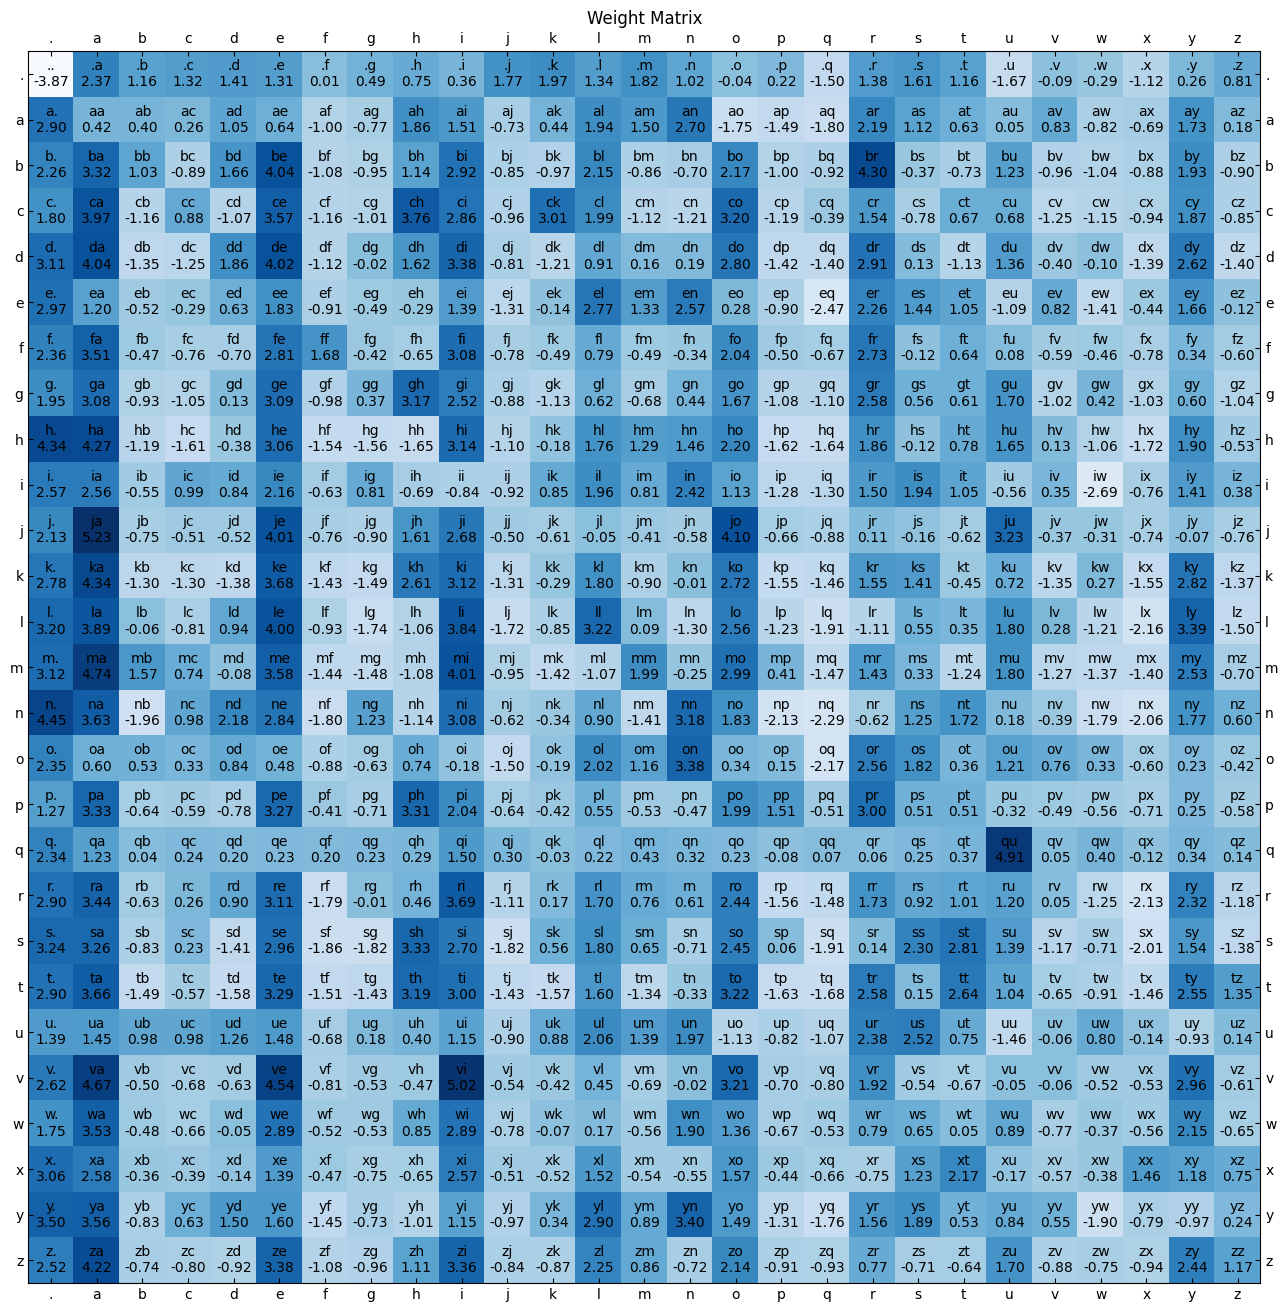

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Creating the figure and the axis
fig, ax = plt.subplots(figsize=(16, 16))

# Creating the heat map
heatmap = ax.imshow(W.detach(), cmap='Blues')

# Adding the index values as annotations
for i in range(total_chrs):
    for j in range(total_chrs):
        bigram = itos[i] + itos[j]
        text = f'{bigram}\n{W[i, j]:.2f}'
        ax.text(j, i, text, ha='center', va='center', color='black')


# Setting the x-axis and y-axis labels
ax.set_xticks(np.arange(total_chrs))
ax.set_xticklabels(sorted(stoi))
ax.set_yticks(np.arange(total_chrs))
ax.set_yticklabels(sorted(stoi))

# Adding x-axis and y-axis ticks on all four sides
ax.tick_params(top=True, bottom=True, left=True, right=True, direction='in', 
               labeltop=True, labelbottom=True, labelleft=True, labelright=True)


# Setting the title and displaying the plot
ax.set_title('Weight Matrix')
plt.show()

#### smoothining in weights based method

In the stastistical bigram model, when adding a constant to all the counts make the model smooth, the higher the value the more smooth the model, when the value is very high, it makes all the counts relatively similar, which makes the distribution uniform and the prediction is just uniform random sampling.

In the case of weights based method, when the weights of the network `W` is equal, and in particular `zero`, than the `xenc @ W` will be all zero. Exponentiating them and normalizing will give same value to all the outputs, which in turn is similar to uniform random sampling.

Hence to smoothen the model, we can force the weights to be closer to `zero`.

In [ ]:
# loss with regularization
loss = -prob[torch.arange(num_elements), ys].log().mean() + 0.01 * (W**2).mean()
# W**2 makes all the components of weights as positive
# Since the overall loss has to decrease, the model can't increase the weights value, as that
# will increase the 2nd term, hence increasing the loss.
# Model has to now manage both terms, redicing the nll loss and also the regularization loss
# 0.01 is the factor, which decided the power of the regularization. Higher the factor closer
# the weights are to zero.

### Inference

#### Using statistical model

In [ ]:
g = torch.Generator().manual_seed(2147483647) # deterministic generator for sampling

for _ in range(7):
    ix = 0 # starting with `.` idx
    out = []
    while True:
        p = P[ix] # Get the row of the current character token
        # p = N[ix].float() # Get the row of the current character token
        # p /= p.sum() # Normalize    
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample next token
        if ix == 0: # Sample end token
            break
        out.append(itos[ix])
    print(''.join(out))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai


### Using Neural Netowrk

In [ ]:
g = torch.Generator().manual_seed(2147483647) # deterministic generator for sampling

for _ in range(7):
    ix = 0 # starting with `.` idx
    out = []
    while True:

        xenc = F.one_hot(torch.tensor([ix]), num_classes=total_chrs).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts/counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample next token
        if ix == 0: # Sample end token
            break
        out.append(itos[ix])
    print(''.join(out))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai


#### 🤯 Same Results for both the models